In [1]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

In [ ]:
 ! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

In [ ]:
!kaggle datasets download -d odins0n/ucf-crime-dataset

In [ ]:
from zipfile import ZipFile

zip_path= "C:\\Users\\user\\Desktop\\raushan\\ucf-crime-dataset.zip"

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('C:\\Users\\user\\Desktop\\raushan')
print('unzipping completed')   

In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
from glob import glob
import torch
from sklearn.model_selection import train_test_split

# Define a function to collect all frame paths and their respective labels
def load_dataset(root_dir):
    classes = os.listdir(root_dir)
    frame_paths = []
    labels = []

    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(root_dir, class_name)
        images = glob(os.path.join(class_path, "*.png"))
        frame_paths.extend(images)
        labels.extend([class_idx] * len(images))

    return frame_paths, labels

# Load train and test datasets
train_root_dir = "C:\\Users\\user\\Desktop\\raushan\\Train"
test_root_dir = "C:\\Users\\user\\Desktop\\raushan\\Test"

train_frame_paths, train_labels = load_dataset(train_root_dir)
test_frame_paths, test_labels = load_dataset(test_root_dir)

# Optionally split the train data for validation
train_frame_paths, val_frame_paths, train_labels, val_labels = train_test_split(
    train_frame_paths, train_labels, test_size=0.1, random_state=42,train_size=0.9
)


In [2]:
print(len(train_frame_paths))
print(len(val_frame_paths))
print(len(test_frame_paths))

1139710
126635
111308


In [2]:
import os
import torch
from glob import glob
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

# Define a custom dataset to handle the UCF Crime frames and group them into sequences
class FrameSequenceDataset(Dataset):
    def __init__(self, root_dir, frame_count=16, transform=None):
        self.root_dir = root_dir
        self.frame_count = frame_count
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.frame_sequences = []
        self.labels = []

        # Debug: Print the classes found
        print("Classes found:", self.classes)

        # Iterate over each class and gather frame sequences
        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            frames = sorted(glob(os.path.join(class_path, "*.png")))
            print(f"Found {len(frames)} frames in {class_name}")  # Debug: Check frames in each class

            # Group frames into sequences of self.frame_count
            for i in range(0, len(frames), self.frame_count):
                frame_seq = frames[i:i + self.frame_count]
                if len(frame_seq) == self.frame_count:
                    self.frame_sequences.append(frame_seq)
                    self.labels.append(class_idx)

        # Debug: Print the number of sequences created
        print("Total sequences created:", len(self.frame_sequences))

    def __len__(self):
        return len(self.frame_sequences)

    def __getitem__(self, idx):
        frame_seq_paths = self.frame_sequences[idx]
        label = self.labels[idx]

        # Load and preprocess frames
        frames = [Image.open(frame_path).convert("RGB") for frame_path in frame_seq_paths]
        if self.transform:
            frames = [self.transform(frame) for frame in frames]

        # Stack the frames (TimeSformer expects them as a tensor)
        frames = torch.stack(frames)

        return frames, torch.tensor(label)

# Image transforms (resize to 224x224 for TimeSformer)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    #transforms.RandomHoizontalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(),
])

# Load the train dataset
train_dataset = FrameSequenceDataset(root_dir="C:\\Users\\user\\Desktop\\raushan\\Train", frame_count=16, transform=transform)
#val_dataset = FrameSequenceDataset(root_dir="C:\\Users\\user\\Desktop\\raushan\\val", frame_count=16, transform=transform)  # Remove if not needed
test_dataset = FrameSequenceDataset(root_dir="C:\\Users\\user\\Desktop\\raushan\\Test", frame_count=16, transform=transform)

# DataLoader
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)  # Remove if not needed
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Check the lengths of the datasets
print("Train dataset length:", len(train_dataset))
# print("Validation dataset length:", len(val_dataset))  # Remove if not needed
print("Test dataset length:", len(test_dataset))


Classes found: ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']
Found 19076 frames in Abuse
Found 26397 frames in Arrest
Found 24421 frames in Arson
Found 10360 frames in Assault
Found 39504 frames in Burglary
Found 18753 frames in Explosion
Found 24684 frames in Fighting
Found 947768 frames in NormalVideos
Found 23486 frames in RoadAccidents
Found 41493 frames in Robbery
Found 7140 frames in Shooting
Found 24835 frames in Shoplifting
Found 44802 frames in Stealing
Found 13626 frames in Vandalism
Total sequences created: 79141
Classes found: ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']
Found 297 frames in Abuse
Found 3365 frames in Arrest
Found 2793 frames in Arson
Found 2657 frames in Assault
Found 7657 frames in Burglary
Found 6510 fram

In [14]:
len(train_loader)

19786

In [3]:
import torch
torch.cuda.is_available()

True

In [ ]:
pip install transformers

In [4]:
from transformers import AutoConfig, AutoModelForVideoClassification

config = AutoConfig.from_pretrained("facebook/timesformer-base-finetuned-k400")
config.image_size = 64
config.num_labels = 14
config.patch_size = 8

model = AutoModelForVideoClassification.from_pretrained("facebook/timesformer-base-finetuned-k400", config =config, ignore_mismatched_sizes=True)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- timesformer.embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 65, 768]) in the model instantiated
- timesformer.embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 3, 8, 8]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([14, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkp

In [5]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForVideoClassification

processor = AutoImageProcessor.from_pretrained("facebook/timesformer-base-finetuned-k400")
#model = AutoModelForVideoClassification.from_pretrained("facebook/timesformer-base-finetuned-k400",
                                                      # num_labels=len(train_dataset.classes), # This will correctly set the output to 14 classes
                                                      # ignore_mismatched_sizes=True) # This will handle the size mismatch in the classifier layer.

In [17]:
from transformers import AdamW
import torch


# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
'''
# Freeze the first few layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final classification head for fine-tuning
for param in model.classifier.parameters():
    param.requires_grad = True

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)
'''
# Define optimizer and learning rate
optimizer = AdamW(model.parameters(), lr=1e-4)


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
import torch
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import os

# Initialize TensorBoard for visualizing the training and validation loss
writer = SummaryWriter(log_dir="runs/experiment_1")

# Path where you want to save the model
save_dir = "C:\\Users\\user\\Desktop\\raushan\\"  # Your desired path

# Make sure the save directory exists
os.makedirs(save_dir, exist_ok=True)

# Training loop
num_epochs = 10  # Increased number of epochs for better training
best_val_loss = float("inf")

# Ensure model is on the right device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training and validation loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        frames, labels = batch
        frames = frames.to(device)  # Move frames to GPU/CPU
        labels = labels.to(device)  # Move labels to GPU/CPU

        # Forward pass
        outputs = model(frames, labels=labels)
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    # Log the training loss to TensorBoard
    writer.add_scalar('Loss/train', avg_train_loss, epoch)

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            frames, labels = batch
            frames = frames.to(device)
            labels = labels.to(device)

            outputs = model(frames, labels=labels)
            val_loss += outputs.loss.item()

    avg_val_loss = val_loss / len(test_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}")

    # Log the validation loss to TensorBoard
    writer.add_scalar('Loss/validation', avg_val_loss, epoch)

    # Save the best model based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        
        # Save the model, optimizer, and epoch to a checkpoint
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
        }
        checkpoint_path = os.path.join(save_dir, f"best_model_epoch_{epoch+1}.pth")
        torch.save(checkpoint, checkpoint_path)
        print(f"Best model saved at epoch {epoch+1} to {checkpoint_path}")

# Close the TensorBoard writer
writer.close()

print("Training complete!")


Epoch 1/10 - Training:   0%|          | 0/19786 [00:00<?, ?it/s]

Epoch 1/10 - Training: 100%|██████████| 19786/19786 [2:14:49<00:00,  2.45it/s]  


Epoch [1/10], Train Loss: 0.9368


Epoch 1/10 - Validation: 100%|██████████| 1738/1738 [04:38<00:00,  6.24it/s]


Epoch [1/10], Val Loss: 2.0922
Best model saved at epoch 1 to C:\Users\user\Desktop\raushan\best_model_epoch_1.pth


Epoch 2/10 - Training: 100%|██████████| 19786/19786 [2:04:37<00:00,  2.65it/s]  


Epoch [2/10], Train Loss: 0.6002


Epoch 2/10 - Validation: 100%|██████████| 1738/1738 [04:17<00:00,  6.74it/s]


Epoch [2/10], Val Loss: 2.2485


Epoch 3/10 - Training: 100%|██████████| 19786/19786 [2:04:54<00:00,  2.64it/s]  


Epoch [3/10], Train Loss: 0.3835


Epoch 3/10 - Validation: 100%|██████████| 1738/1738 [04:18<00:00,  6.73it/s]


Epoch [3/10], Val Loss: 2.4470


Epoch 4/10 - Training: 100%|██████████| 19786/19786 [2:03:33<00:00,  2.67it/s]  


Epoch [4/10], Train Loss: 0.2503


Epoch 4/10 - Validation: 100%|██████████| 1738/1738 [04:18<00:00,  6.72it/s]


Epoch [4/10], Val Loss: 2.6340


Epoch 5/10 - Training: 100%|██████████| 19786/19786 [2:03:38<00:00,  2.67it/s]  


Epoch [5/10], Train Loss: 0.1778


Epoch 5/10 - Validation: 100%|██████████| 1738/1738 [04:18<00:00,  6.71it/s]


Epoch [5/10], Val Loss: 3.0518


Epoch 6/10 - Training: 100%|██████████| 19786/19786 [2:02:32<00:00,  2.69it/s]  


Epoch [6/10], Train Loss: 0.1307


Epoch 6/10 - Validation: 100%|██████████| 1738/1738 [04:17<00:00,  6.75it/s]


Epoch [6/10], Val Loss: 2.8561


Epoch 7/10 - Training: 100%|██████████| 19786/19786 [2:01:52<00:00,  2.71it/s]  


Epoch [7/10], Train Loss: 0.1011


Epoch 7/10 - Validation: 100%|██████████| 1738/1738 [04:17<00:00,  6.75it/s]


Epoch [7/10], Val Loss: 2.9865


Epoch 8/10 - Training: 100%|██████████| 19786/19786 [2:02:44<00:00,  2.69it/s]  


Epoch [8/10], Train Loss: 0.0810


Epoch 8/10 - Validation: 100%|██████████| 1738/1738 [04:18<00:00,  6.72it/s]


Epoch [8/10], Val Loss: 3.3868


Epoch 9/10 - Training: 100%|██████████| 19786/19786 [2:02:57<00:00,  2.68it/s]  


Epoch [9/10], Train Loss: 0.0676


Epoch 9/10 - Validation: 100%|██████████| 1738/1738 [04:17<00:00,  6.76it/s]


Epoch [9/10], Val Loss: 3.7142


Epoch 10/10 - Training: 100%|██████████| 19786/19786 [2:01:57<00:00,  2.70it/s]  


Epoch [10/10], Train Loss: 0.0555


Epoch 10/10 - Validation: 100%|██████████| 1738/1738 [04:18<00:00,  6.72it/s]

Epoch [10/10], Val Loss: 3.6198
Training complete!


In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoModelForVideoClassification, AutoConfig
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import os

# Check device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model configuration with 14 output classes
#config = AutoConfig.from_pretrained("facebook/timesformer-base-finetuned-k400", num_labels=14)

# Load pre-trained model, handling shape mismatches
model = AutoModelForVideoClassification.from_pretrained(
    "facebook/timesformer-base-finetuned-k400",
    config=config,
    ignore_mismatched_sizes=True
)

# Replace classifier with a new one for 14 classes
model.classifier = nn.Linear(model.config.hidden_size, 14)
model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Define dataset (replace with actual dataset loading)
# Example: train_dataset should be a PyTorch dataset of video frames and labels
# train_dataset = YourCustomDataset()
total_samples = len(train_dataset)
val_split = int(0.2 * total_samples)  # 20% validation
train_split = total_samples - val_split

train_dataset, val_dataset = random_split(train_dataset, [train_split, val_split])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Output directory for saving models
save_dir = "C://Users//user//Desktop//raushan/"
os.makedirs(save_dir, exist_ok=True)

# Training loop
num_epochs = 10
best_val_loss = float("inf")

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0

    print(f"Epoch {epoch}/{num_epochs} - Training:")
    train_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs} - Training")
    
    for frames, labels in train_bar:
        frames, labels = frames.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(frames).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0

    print(f"Epoch {epoch}/{num_epochs} - Validation:")
    val_bar = tqdm(val_loader, total=len(val_loader), desc=f"Epoch {epoch}/{num_epochs} - Validation")
    
    with torch.no_grad():
        for frames, labels in val_bar:
            frames, labels = frames.to(device), labels.to(device)
            outputs = model(frames).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_bar.set_postfix(loss=loss.item())

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch}/{num_epochs}], Val Loss: {avg_val_loss:.4f}")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = os.path.join(save_dir, f"best_model_epoch_{epoch}.pth")
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch} to {best_model_path}")

    # Save last epoch model
    last_model_path = os.path.join(save_dir, "last_epoch_model.pth")
    torch.save(model.state_dict(), last_model_path)

print("Training complete!")


Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- timesformer.embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 65, 768]) in the model instantiated
- timesformer.embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 3, 8, 8]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([14, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([14]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 - Training:


Epoch 1/10 - Training: 100%|██████████| 6484/6484 [45:06<00:00,  2.40it/s, loss=0.188]  


Epoch [1/10], Train Loss: 1.0305
Epoch 1/10 - Validation:


Epoch 1/10 - Validation: 100%|██████████| 1621/1621 [04:03<00:00,  6.67it/s, loss=0.0539]


Epoch [1/10], Val Loss: 0.8887
Best model saved at epoch 1 to C://Users//user//Desktop//raushan/best_model_epoch_1.pth
Epoch 2/10 - Training:


Epoch 2/10 - Training: 100%|██████████| 6484/6484 [38:48<00:00,  2.78it/s, loss=0.0629] 


Epoch [2/10], Train Loss: 0.8076
Epoch 2/10 - Validation:


Epoch 2/10 - Validation: 100%|██████████| 1621/1621 [03:43<00:00,  7.24it/s, loss=0.0106] 


Epoch [2/10], Val Loss: 0.7775
Best model saved at epoch 2 to C://Users//user//Desktop//raushan/best_model_epoch_2.pth
Epoch 3/10 - Training:


Epoch 3/10 - Training: 100%|██████████| 6484/6484 [38:15<00:00,  2.82it/s, loss=0.0982]  


Epoch [3/10], Train Loss: 0.6695
Epoch 3/10 - Validation:


Epoch 3/10 - Validation: 100%|██████████| 1621/1621 [03:59<00:00,  6.78it/s, loss=0.0045] 


Epoch [3/10], Val Loss: 0.6344
Best model saved at epoch 3 to C://Users//user//Desktop//raushan/best_model_epoch_3.pth
Epoch 4/10 - Training:


Epoch 4/10 - Training: 100%|██████████| 6484/6484 [38:51<00:00,  2.78it/s, loss=0.647]   


Epoch [4/10], Train Loss: 0.5498
Epoch 4/10 - Validation:


Epoch 4/10 - Validation: 100%|██████████| 1621/1621 [04:02<00:00,  6.69it/s, loss=0.00689]


Epoch [4/10], Val Loss: 0.5270
Best model saved at epoch 4 to C://Users//user//Desktop//raushan/best_model_epoch_4.pth
Epoch 5/10 - Training:


Epoch 5/10 - Training: 100%|██████████| 6484/6484 [39:21<00:00,  2.75it/s, loss=2.25]    


Epoch [5/10], Train Loss: 0.4455
Epoch 5/10 - Validation:


Epoch 5/10 - Validation: 100%|██████████| 1621/1621 [04:00<00:00,  6.73it/s, loss=0.000576]


Epoch [5/10], Val Loss: 0.4327
Best model saved at epoch 5 to C://Users//user//Desktop//raushan/best_model_epoch_5.pth
Epoch 6/10 - Training:


Epoch 6/10 - Training: 100%|██████████| 6484/6484 [38:51<00:00,  2.78it/s, loss=0.126]   


Epoch [6/10], Train Loss: 0.3660
Epoch 6/10 - Validation:


Epoch 6/10 - Validation: 100%|██████████| 1621/1621 [03:44<00:00,  7.23it/s, loss=0.00259] 


Epoch [6/10], Val Loss: 0.3715
Best model saved at epoch 6 to C://Users//user//Desktop//raushan/best_model_epoch_6.pth
Epoch 7/10 - Training:


Epoch 7/10 - Training: 100%|██████████| 6484/6484 [39:43<00:00,  2.72it/s, loss=1.61]      


Epoch [7/10], Train Loss: 0.3013
Epoch 7/10 - Validation:


Epoch 7/10 - Validation: 100%|██████████| 1621/1621 [04:04<00:00,  6.64it/s, loss=0.00055] 


Epoch [7/10], Val Loss: 0.3070
Best model saved at epoch 7 to C://Users//user//Desktop//raushan/best_model_epoch_7.pth
Epoch 8/10 - Training:


Epoch 8/10 - Training: 100%|██████████| 6484/6484 [39:11<00:00,  2.76it/s, loss=0.0172]  


Epoch [8/10], Train Loss: 0.2432
Epoch 8/10 - Validation:


Epoch 8/10 - Validation: 100%|██████████| 1621/1621 [03:46<00:00,  7.17it/s, loss=0.00721] 


Epoch [8/10], Val Loss: 0.3761
Epoch 9/10 - Training:


Epoch 9/10 - Training: 100%|██████████| 6484/6484 [38:37<00:00,  2.80it/s, loss=0.0711]  


Epoch [9/10], Train Loss: 0.2036
Epoch 9/10 - Validation:


Epoch 9/10 - Validation: 100%|██████████| 1621/1621 [03:56<00:00,  6.86it/s, loss=0.0248]  


Epoch [9/10], Val Loss: 0.2603
Best model saved at epoch 9 to C://Users//user//Desktop//raushan/best_model_epoch_9.pth
Epoch 10/10 - Training:


Epoch 10/10 - Training: 100%|██████████| 6484/6484 [38:39<00:00,  2.80it/s, loss=0.444]   


Epoch [10/10], Train Loss: 0.1690
Epoch 10/10 - Validation:


Epoch 10/10 - Validation: 100%|██████████| 1621/1621 [03:46<00:00,  7.16it/s, loss=0.000974]


Epoch [10/10], Val Loss: 0.2580
Best model saved at epoch 10 to C://Users//user//Desktop//raushan/best_model_epoch_10.pth
Training complete!


In [18]:
import torch
torch.cuda.empty_cache()  # Clears unused memory


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoModelForVideoClassification
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import os

# Check device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path to the saved checkpoint (from epoch 10)
checkpoint_path = "C://Users//user//Desktop//raushan//best_model_epoch_13.pth"

# Load pre-trained model
model = AutoModelForVideoClassification.from_pretrained(
    "facebook/timesformer-base-finetuned-k400",
    config=config,
    ignore_mismatched_sizes=True
)


# Replace classifier with a new one for 14 classes (ensuring correct output shape)
model.classifier = nn.Linear(model.config.hidden_size, 14)

# Load the saved checkpoint
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# Move model to the appropriate device
model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Define dataset (ensure `train_dataset` is properly defined)
total_samples = len(train_dataset)
val_split = int(0.2 * total_samples)  # 20% validation
train_split = total_samples - val_split

train_dataset, val_dataset = random_split(train_dataset, [train_split, val_split])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Output directory for saving models
save_dir = "C://Users//user//Desktop//raushan/"
os.makedirs(save_dir, exist_ok=True)

# Resume training from epoch 11
start_epoch = 15
num_epochs = 20
best_val_loss = float("inf")

for epoch in range(start_epoch, num_epochs + 1):
    model.train()
    total_loss = 0

    print(f"Epoch {epoch}/{num_epochs} - Training:")
    train_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs} - Training")

    for frames, labels in train_bar:
        frames, labels = frames.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(frames).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0

    print(f"Epoch {epoch}/{num_epochs} - Validation:")
    val_bar = tqdm(val_loader, total=len(val_loader), desc=f"Epoch {epoch}/{num_epochs} - Validation")

    with torch.no_grad():
        for frames, labels in val_bar:
            frames, labels = frames.to(device), labels.to(device)
            outputs = model(frames).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_bar.set_postfix(loss=loss.item())

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch}/{num_epochs}], Val Loss: {avg_val_loss:.4f}")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = os.path.join(save_dir, f"best_model_epoch_{epoch}.pth")
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch} to {best_model_path}")

    # Save last epoch model
    last_model_path = os.path.join(save_dir, "last_epoch_model.pth")
    torch.save(model.state_dict(), last_model_path)

print("Training complete!")


Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- timesformer.embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 65, 768]) in the model instantiated
- timesformer.embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 3, 8, 8]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([14, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([14]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 15/20 - Training:


Epoch 15/20 - Training: 100%|██████████| 5187/5187 [33:04<00:00,  2.61it/s, loss=0.000763]


Epoch [15/20], Train Loss: 0.0719
Epoch 15/20 - Validation:


Epoch 15/20 - Validation: 100%|██████████| 1297/1297 [03:21<00:00,  6.42it/s, loss=1.19e-5] 


Epoch [15/20], Val Loss: 0.0742
Best model saved at epoch 15 to C://Users//user//Desktop//raushan/best_model_epoch_15.pth
Epoch 16/20 - Training:


Epoch 16/20 - Training: 100%|██████████| 5187/5187 [30:15<00:00,  2.86it/s, loss=0.000432]


Epoch [16/20], Train Loss: 0.0603
Epoch 16/20 - Validation:


Epoch 16/20 - Validation: 100%|██████████| 1297/1297 [03:30<00:00,  6.16it/s, loss=1.01e-6] 


Epoch [16/20], Val Loss: 0.1071
Epoch 17/20 - Training:


Epoch 17/20 - Training: 100%|██████████| 5187/5187 [31:36<00:00,  2.73it/s, loss=2.1e-5]  


Epoch [17/20], Train Loss: 0.0564
Epoch 17/20 - Validation:


Epoch 17/20 - Validation: 100%|██████████| 1297/1297 [03:09<00:00,  6.83it/s, loss=1.07e-5] 


Epoch [17/20], Val Loss: 0.0646
Best model saved at epoch 17 to C://Users//user//Desktop//raushan/best_model_epoch_17.pth
Epoch 18/20 - Training:


Epoch 18/20 - Training: 100%|██████████| 5187/5187 [30:21<00:00,  2.85it/s, loss=0.0271]  


Epoch [18/20], Train Loss: 0.0508
Epoch 18/20 - Validation:


Epoch 18/20 - Validation: 100%|██████████| 1297/1297 [03:02<00:00,  7.10it/s, loss=8.34e-7] 


Epoch [18/20], Val Loss: 0.0895
Epoch 19/20 - Training:


Epoch 19/20 - Training: 100%|██████████| 5187/5187 [30:16<00:00,  2.85it/s, loss=0.0181]  


Epoch [19/20], Train Loss: 0.0473
Epoch 19/20 - Validation:


Epoch 19/20 - Validation: 100%|██████████| 1297/1297 [03:03<00:00,  7.08it/s, loss=1.73e-5] 


Epoch [19/20], Val Loss: 0.0970
Epoch 20/20 - Training:


Epoch 20/20 - Training: 100%|██████████| 5187/5187 [31:05<00:00,  2.78it/s, loss=2.06e-6]  


Epoch [20/20], Train Loss: 0.0421
Epoch 20/20 - Validation:


Epoch 20/20 - Validation: 100%|██████████| 1297/1297 [03:18<00:00,  6.52it/s, loss=4.53e-6] 


Epoch [20/20], Val Loss: 0.0830
Training complete!


In [19]:
torch.cuda.set_per_process_memory_fraction(0.9, device=0)  # Allocates 90% of GPU memory


In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoModelForVideoClassification, AutoConfig
from tqdm import tqdm
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model configuration
config = AutoConfig.from_pretrained("facebook/timesformer-base-finetuned-k400")
config.image_size = 64  # Set same as training
config.num_labels = 14  # Number of classes
config.patch_size = 8

# Load model
model = AutoModelForVideoClassification.from_pretrained(
    "facebook/timesformer-base-finetuned-k400",
    config=config,
    ignore_mismatched_sizes=True
)

# Load trained weights
model_path = "C:\\Users\\user\\Desktop\\raushan\\best_model_epoch_17.pth"  # Change if using best model
assert os.path.exists(model_path), f"Model file not found: {model_path}"
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Define label mapping from dataset
class_labels = os.listdir("C:\\Users\\user\\Desktop\\raushan\\Train")  # Same as used in training
print("Class labels:", class_labels)

# Initialize lists to store predictions and ground truths
all_preds = []
all_labels = []

# Evaluate on test dataset
print("\nEvaluating on Test Dataset...\n")
with torch.no_grad():
    for frames, labels in tqdm(test_loader, total=len(test_loader), desc="Testing"):
        frames, labels = frames.to(device), labels.to(device)

        outputs = model(frames).logits  # Get model predictions
        preds = torch.argmax(outputs, dim=1)  # Get predicted class indices

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert indices to class names
predicted_labels = [class_labels[i] for i in all_preds]
actual_labels = [class_labels[i] for i in all_labels]

# Compute accuracy, precision, recall, and F1-score
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")

# Print results
print("\nTest Performance Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Print a few predictions for reference
print("\nSample Predictions:")
for i in range(10):  # Print 10 sample predictions
    if i < len(predicted_labels):
        print(f"Actual: {actual_labels[i]}  |  Predicted: {predicted_labels[i]}")


Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- timesformer.embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 65, 768]) in the model instantiated
- timesformer.embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 3, 8, 8]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([14, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([14]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class labels: ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']

Evaluating on Test Dataset...



Testing:  45%|████▍     | 782/1738 [02:47<02:24,  6.60it/s]

In [8]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import numpy as np
from transformers import AutoModelForVideoClassification, AutoConfig

# Set device (Use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define class labels (Update this with your actual labels)
CLASS_LABELS = {
    0: "Abuse",
    1: "Arrest",
    2: "Arson",
    3: "Assault",
    4: "Burglary",
    5: "Explosion",
    6: "Fighting",
    7: "Normalvideos",
    8: "RoadAccidents",
    9: "Robbery",
    10: "Shooting",
    11: "Shoplifting",
    12: "Stealing",
    13: "Vandalism"  # Example: Update these labels accordingly
}

# Load trained model function
def load_trained_model(model_path):
    # Load model config
    config = AutoConfig.from_pretrained("facebook/timesformer-base-finetuned-k400")
    config.image_size = 64  # Ensure it matches training config
    config.num_labels = 14
    config.patch_size = 8

    # Load model with modified config
    model = AutoModelForVideoClassification.from_pretrained(
        "facebook/timesformer-base-finetuned-k400",
        config=config,
        ignore_mismatched_sizes=True
    )
    
    # Replace classifier with 14-class output
    model.classifier = torch.nn.Linear(model.config.hidden_size, 14)
    
    # Load trained weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model
# Function to extract frames from a video
def extract_frames(video_path, num_frames=8, frame_size=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if total_frames == 0:
        print("Error: Cannot read video.")
        return None

    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    frames = []

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(frame_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.45, 0.45, 0.45], std=[0.225, 0.225, 0.225])
    ])

    for i in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = transform(frame)
        frames.append(frame)

    cap.release()

    if len(frames) < num_frames:
        print("Error: Not enough frames extracted.")
        return None  # Return None if not enough frames are available

    return torch.stack(frames)  # Shape: (num_frames, 3, 224, 224)

# Function to predict class from a video
def predict_on_video(video_path, model):
    frames = extract_frames(video_path)
    if frames is None:
        return None

    frames = frames.unsqueeze(0).to(device)  # Add batch dimension: (1, num_frames, 3, 224, 224)

    with torch.no_grad():
        outputs = model(frames).logits  # Get model predictions
        predicted_class_idx = torch.argmax(outputs, dim=1).item()  # Get predicted class index

    # Get class label from dictionary
    predicted_label = CLASS_LABELS.get(predicted_class_idx, "Unknown")

    return predicted_class_idx, predicted_label

# Load trained model
model_path = "C:\\Users\\user\Desktop\\raushan\\best_model_epoch_12.pth"  # Change this path
model = load_trained_model(model_path)

# Test on a video
video_path = "C:\\Users\\user\\Desktop\\raushan\\mixkit-strong-female-mixed-martial-arts-fighter-40991-hd-ready.mp4"  # Change this path
pred_class_idx, predicted_label = predict_on_video(video_path, model)

if predicted_label is not None:
    print(f"Predicted Class Index: {pred_class_idx}")
    print(f"Predicted Label: {predicted_label}")
else:
    print("Prediction failed.")


<>:106: SyntaxWarning: invalid escape sequence '\D'
<>:106: SyntaxWarning: invalid escape sequence '\D'
C:\Users\user\AppData\Local\Temp\ipykernel_2800\1228025479.py:106: SyntaxWarning: invalid escape sequence '\D'
  model_path = "C:\\Users\\user\Desktop\\raushan\\best_model_epoch_12.pth"  # Change this path
Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- timesformer.embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 65, 768]) in the model instantiated
- timesformer.embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 3, 8, 8]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([14, 768]) in the model instantiated
- classifier.bias: found shap

Predicted Class Index: 3
Predicted Label: Assault


In [11]:
import torch
import cv2
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
def load_trained_model(model_path="C:\\Users\\user\\Desktop\\raushan\\best_model_epoch_10.pth"):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print("Model loaded successfully!")
    return model

# Read video frames using OpenCV
def read_video_opencv(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),  # Resize frames to match model input
        transforms.ToTensor(),
    ])
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        frames.append(transform(frame))
    
    cap.release()
    
    if len(frames) == 0:
        raise ValueError("No frames were extracted from the video!")
    
    return torch.stack(frames)

# Predict the class of a video
def predict_on_video(video_path, model):
    frames = read_video_opencv(video_path)  # Extract frames
    frames = frames.unsqueeze(0).to(device)  # Add batch dimension
    
    with torch.no_grad():
        outputs = model(frames).logits  # Get model output
        pred_class = torch.argmax(outputs, dim=1).item()  # Get predicted class
    
    return pred_class

# Example usage
model = load_trained_model("C:\\Users\\user\\Desktop\\raushan\\best_model_epoch_10.pth")  # Load trained model
video_path = "C:\\Users\\user\\Desktop\\raushan\\videoplayback (online-video-cutter.com).mp4"  # Change this to your video file path
predicted_class = predict_on_video(video_path, model)
print(f"Predicted Class: {predicted_class}")


Model loaded successfully!


OutOfMemoryError: CUDA out of memory. Tried to allocate 120.88 GiB. GPU 0 has a total capacity of 47.99 GiB of which 40.60 GiB is free. Of the allocated memory 5.64 GiB is allocated by PyTorch, and 136.37 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [49]:
# Prediction on test dataset
def predict_on_test():
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in test_loader:
            frames, _ = batch
            frames = frames.to(device)
            outputs = model(frames).logits
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.extend(preds)
    return predictions


In [50]:
# Video prediction function
def predict_on_video(video_path):
    frames, _, _ = read_video(video_path, pts_unit='sec')
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])
    frames = torch.stack([transform(frame) for frame in frames])
    frames = frames.unsqueeze(0).to(device)  # Add batch dimension
    
    model.eval()
    with torch.no_grad():
        outputs = model(frames).logits
        pred = torch.argmax(outputs, dim=1).item()
    
    return pred


In [51]:
predict_on_video("C:\\Users\\user\\Desktop\\raushan\\mixkit-strong-female-mixed-martial-arts-fighter-40991-hd-ready.mp4")

ImportError: PyAV is not installed, and is necessary for the video operations in torchvision.
See https://github.com/mikeboers/PyAV#installation for instructions on how to
install PyAV on your system.


In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoConfig, AutoModelForVideoClassification
from torch.utils.data import DataLoader
import numpy as np

# Function to load the model
def load_model(checkpoint_path, config_path="facebook/timesformer-base-finetuned-k400"):
    # Load the configuration
    config = AutoConfig.from_pretrained(config_path)
    config.image_size = 64  # Ensure the image size matches your fine-tuned model's setting
    config.num_labels = 14  # Number of output classes
    config.patch_size = 8  # Patch size

    # Load the model
    model = AutoModelForVideoClassification.from_pretrained(config_path, config=config, ignore_mismatched_sizes=True)
    
    # Load the checkpoint (fine-tuned weights)
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['C:\\Users\\user\\Desktop\\raushan'])
    model.eval()  # Set the model to evaluation mode
    return model

# Evaluation function to compute accuracy, precision, recall, F1 score, and confusion matrix
def evaluate_model(model, dataloader, device):
    all_preds = []
    all_labels = []

    # Iterate over the validation or test set
    with torch.no_grad():
        for batch in dataloader:
            frames, labels = batch
            frames = frames.to(device)
            labels = labels.to(device)

            # Forward pass: Get model predictions
            outputs = model(frames)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)  # Get the class with the highest logit

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Plot the confusion matrix
    plot_confusion_matrix(cm)

    return accuracy, precision, recall, f1, cm

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, labels=None):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage
checkpoint_path = "C:\\Users\\user\\Desktop\\raushan\\best_model_epoch_11.pth"  # Path to your fine-tuned model checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
model = load_model(checkpoint_path)
model.to(device)

# Assuming you have a DataLoader for your test set (e.g., `test_loader`):
# Replace this with your actual test or validation DataLoader
# test_loader = DataLoader(...)

# Evaluate the model on the test set
accuracy, precision, recall, f1, cm = evaluate_model(model, test_loader, device)



Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- timesformer.embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 65, 768]) in the model instantiated
- timesformer.embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 3, 8, 8]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([14, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([14]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyError: 'C:\\Users\\user\\Desktop\\raushan'

Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- timesformer.embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 65, 768]) in the model instantiated
- timesformer.embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 3, 8, 8]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([14, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([14]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Checkpoint Keys: odict_keys(['timesformer.embeddings.cls_token', 'timesformer.embeddings.position_embeddings', 'timesformer.embeddings.time_embeddings', 'timesformer.embeddings.patch_embeddings.projection.weight', 'timesformer.embeddings.patch_embeddings.projection.bias', 'timesformer.encoder.layer.0.attention.attention.qkv.weight', 'timesformer.encoder.layer.0.attention.attention.qkv.bias', 'timesformer.encoder.layer.0.attention.output.dense.weight', 'timesformer.encoder.layer.0.attention.output.dense.bias', 'timesformer.encoder.layer.0.intermediate.dense.weight', 'timesformer.encoder.layer.0.intermediate.dense.bias', 'timesformer.encoder.layer.0.output.dense.weight', 'timesformer.encoder.layer.0.output.dense.bias', 'timesformer.encoder.layer.0.layernorm_before.weight', 'timesformer.encoder.layer.0.layernorm_before.bias', 'timesformer.encoder.layer.0.layernorm_after.weight', 'timesformer.encoder.layer.0.layernorm_after.bias', 'timesformer.encoder.layer.0.temporal_layernorm.weight', 't

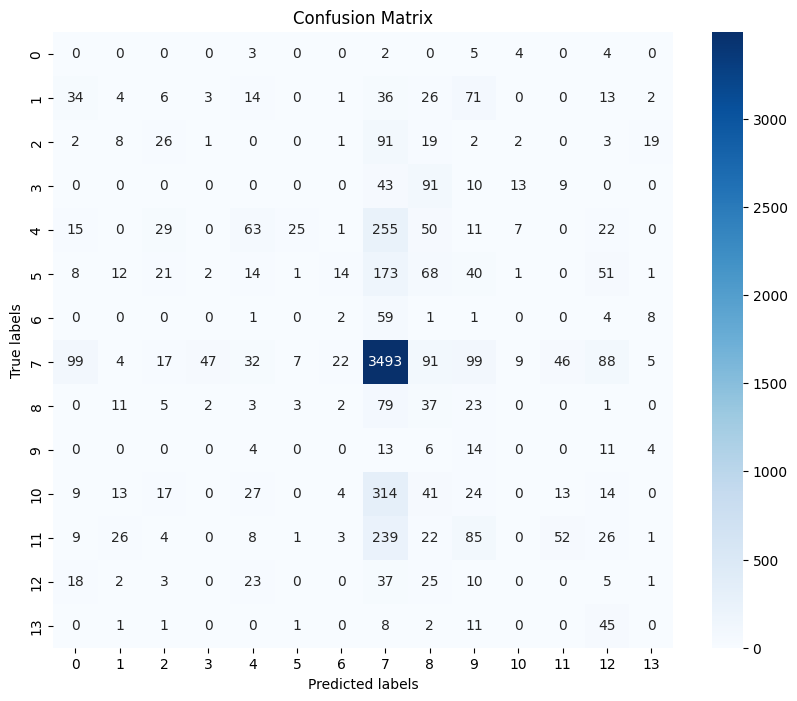

In [10]:
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoConfig, AutoModelForVideoClassification
from torch.utils.data import DataLoader
import numpy as np

# Function to load the model
def load_model(checkpoint_path, config_path="facebook/timesformer-base-finetuned-k400"):
    # Load the configuration
    config = AutoConfig.from_pretrained(config_path)
    config.image_size = 64  # Ensure the image size matches your fine-tuned model's setting
    config.num_labels = 14  # Number of output classes
    config.patch_size = 8  # Patch size

    # Load the model
    model = AutoModelForVideoClassification.from_pretrained(
        config_path, 
        config=config, 
        ignore_mismatched_sizes=True
    )

    # Load the checkpoint (fine-tuned weights)
    checkpoint = torch.load(checkpoint_path, map_location=torch.device("cpu"))

    # Debug: Print available keys in the checkpoint
    print("Checkpoint Keys:", checkpoint.keys())

    # Load model weights (handling different save formats)
    if "model_state_dict" in checkpoint:  # If saved with torch.save(model.state_dict(), path)
        model.load_state_dict(checkpoint["model_state_dict"])
    else:  # If saved with torch.save(model, path)
        model.load_state_dict(checkpoint)

    model.eval()  # Set model to evaluation mode
    return model

# Function to evaluate the model
def evaluate_model(model, dataloader, device):
    all_preds = []
    all_labels = []

    model.to(device)  # Move model to GPU/CPU

    # Iterate over the test dataset
    with torch.no_grad():
        for batch in dataloader:
            frames, labels = batch
            frames = frames.to(device)
            labels = labels.to(device)

            # Forward pass: Get model predictions
            outputs = model(frames)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)  # Get the class with the highest probability

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Plot the confusion matrix
    plot_confusion_matrix(cm, labels=list(range(14)))  # Adjust if you have class names

    return accuracy, precision, recall, f1, cm

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Path to the fine-tuned model checkpoint
checkpoint_path = "C:\\Users\\user\\Desktop\\raushan\\best_model_epoch_12.pth"

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = load_model(checkpoint_path)
model.to(device)

# Evaluate the model on the test set
accuracy, precision, recall, f1, cm = evaluate_model(model, test_loader, device)
